In [3]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Part 1. Dataset moons

In [4]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

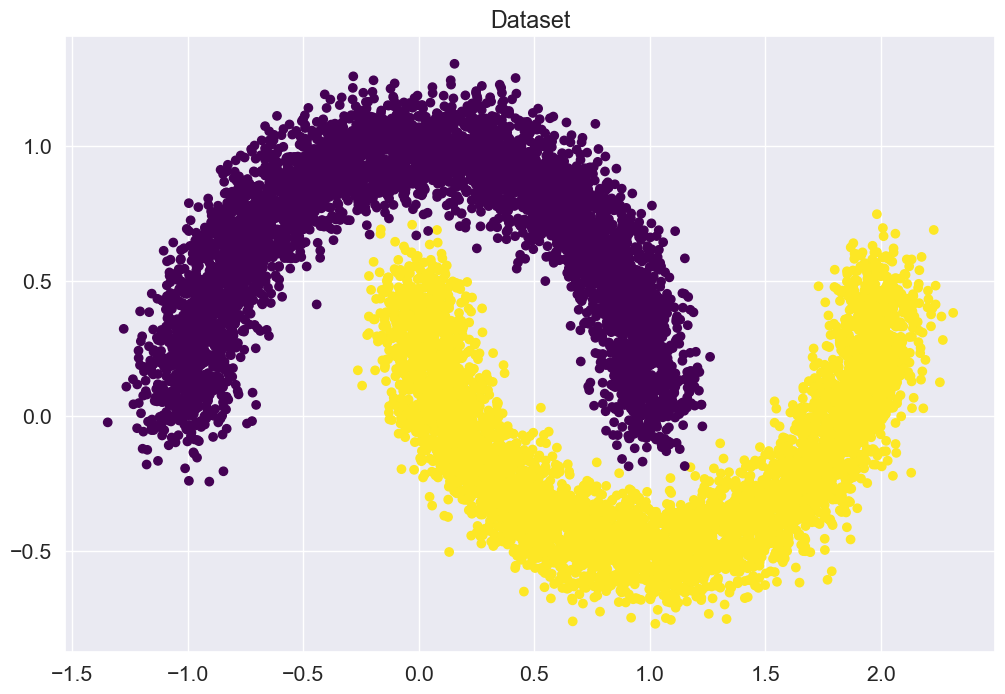

In [5]:
plt.figure(figsize=(12, 8))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

###  Data loading
1.   `Dataset` loads each object separatly.

2.   `DataLoader` Group objects from 'Dataset' in batch.

Since our datacet is small enough we will use `TensorDataset`. 

In [7]:
X_train_t = torch.from_numpy(X_train)
y_train_t = torch.from_numpy(y_train)
X_val_t =  torch.from_numpy(X_val)
y_val_t = torch.from_numpy(y_val)

In [8]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Reminder**
Let's take a look at what happens in logistic regression. At the input, we have an object-feature matrix X and a column-vector $y$ - labels from $\{0, 1\}$ for each object. We want to find a weight matrix $W$ and a bias $b$ (bias) such that our $XW + b$ model will somehow predict the object's class. As you can see at the output, our model can produce a number in the range from $(-\infty;\infty)$. This output is usually called "logits" (logits). We need to transfer it to the interval from $[0;1]$ in order for it to give us the probability that the object belongs to cash register one, it is also better that this function be monotonic, quickly calculated, have a derivative and have $-\infty$ the value $0$, and on $+\infty$ it had the value $1$. Such a class of functions is called a sigmoid. Most often, as a sigmoid, they take
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Logistic regression implementation

Below is a PyTorch module that implements $logits = XW + b$, where $W$ and $b$ are parameters (`nn.Parameter`) of the model. In other words, here I implement the `nn.Linear` module with my own hands. Let's initialize the weights with a normal distribution (`torch.randn`).

In [9]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features, dtype=torch.float64))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(out_features, dtype=torch.float64))

    def forward(self, x):
        x = x.to(torch.float64)
        x =  x @ self.weights
        if self.bias:
            x += self.bias_term
        return x

In [10]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

In [11]:
for param in linear_regression.parameters():
    print(param, param.size())

Parameter containing:
tensor([ 0.8919, -0.6547], dtype=torch.float64, requires_grad=True) torch.Size([2])
Parameter containing:
tensor([0.6614], dtype=torch.float64, requires_grad=True) torch.Size([1])


### Train loop

Training Loop Pseudocode:

```python
for epoch in range(max_epochs): # <----------- iterate over the dataset multiple times
     for x_batch, y_batch in dataset: # <------ iterate over the dataset. Since we use SGD and not GD, we take batches of a given size
         optimizer.zero_grad() # <------------- reset model gradients
         outp = model(x_batch) # <------------- get logs from model
         loss = loss_func(outp, y_batch) # <--- calculate "loss" for logistic regression
         loss.backward() # <------------------- calculate gradients
         optimizer.step() # <----------------- doing a gradient descent step
         if convergence: # <------------------- in case of convergence exit the loop
             break
```

The code below adds `accuracy` and `loss` logging.

###  Implementation of the learning cycle

In [12]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp =  linear_regression(X_batch.to(torch.float64))
        loss =  loss_function(outp, y_batch.to(torch.float64))
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities = torch.sigmoid(outp)
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)
        
        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            # print(it, epoch, len(train_dataloader))
            print(f"\nIteration: {it + epoch * len(train_dataloader)}", "\nConvergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.71875
Iteration: 100
Batch accuracy: 0.828125
Iteration: 200
Batch accuracy: 0.8359375
Iteration: 300
Batch accuracy: 0.9140625
Iteration: 400
Batch accuracy: 0.890625
Iteration: 500
Batch accuracy: 0.90625
Iteration: 600
Batch accuracy: 0.8828125

Iteration: 637 
Convergence. Stopping iterations.


### Visualize results

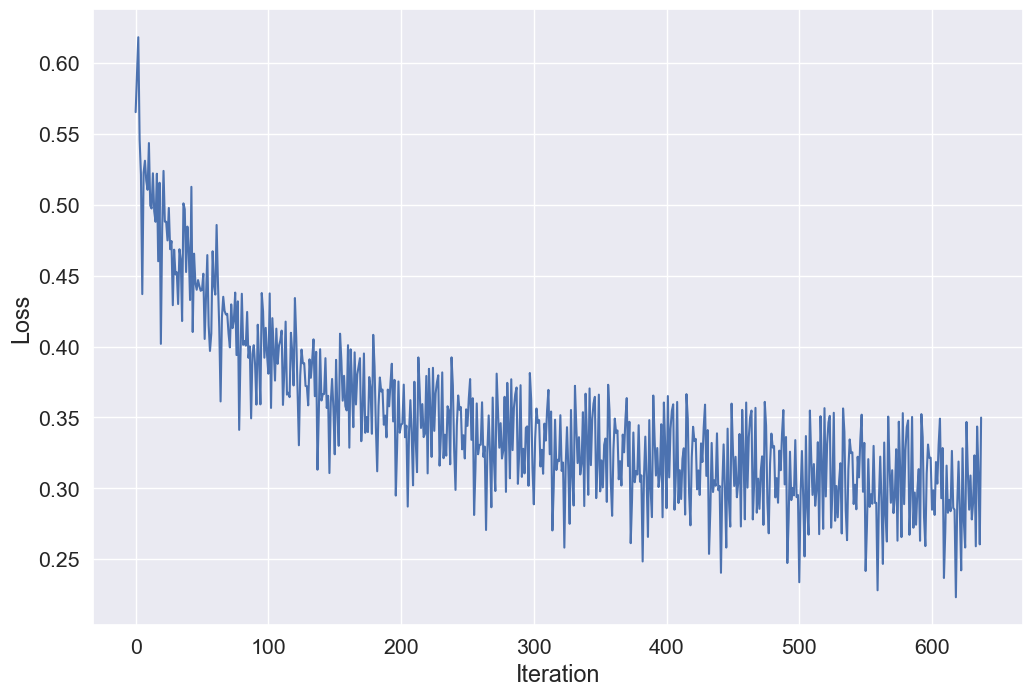

In [13]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

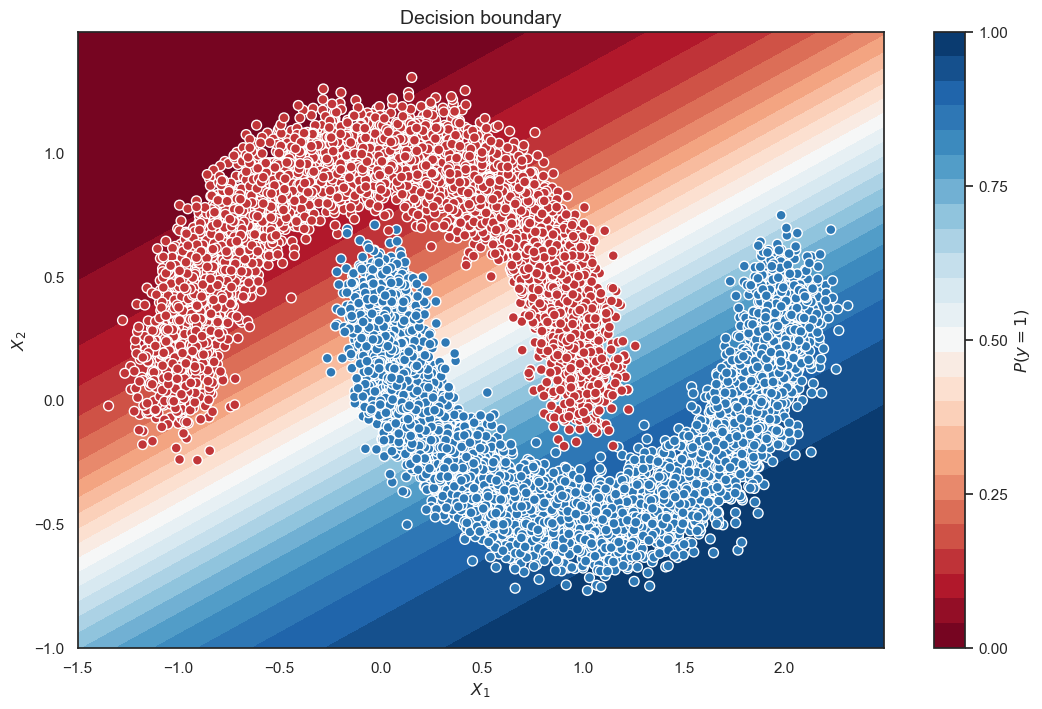

In [14]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(13, 8))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Implement predict and calculate accuracy on test.

In [15]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        probabilities = torch.sigmoid(model(x_batch))
        preds = (probabilities > 0.5).type(torch.long)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [16]:
from sklearn.metrics import accuracy_score

y_pred = predict(val_dataloader, linear_regression)
accuracy_score(y_pred, y_val_t)

0.8672

# Part 2. MNIST Dataset
The MNIST dataset contains handwritten numbers. Let's load the dataset and create DataLoaders. An example can be found in the Seminar on Fully Connected Neural Networks.

In [19]:
import os
from torchvision.datasets import MNIST
import torchvision.transforms as tfs

data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader =  torch.utils.data.DataLoader(train_dataset, batch_size=4, num_workers = 2, shuffle = True)
valid_dataloader =  torch.utils.data.DataLoader(val_dataset, batch_size=4, num_workers = 2, shuffle = False)

100%|██████████████████████████████████████████████████████████████████| 9912422/9912422 [00:00<00:00, 18733325.03it/s]


Extracting ./MNIST\raw\train-images-idx3-ubyte.gz to ./MNIST\raw



100%|██████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 14652920.51it/s]


Extracting ./MNIST\raw\train-labels-idx1-ubyte.gz to ./MNIST\raw



100%|███████████████████████████████████████████████████████████████████| 1648877/1648877 [00:00<00:00, 5776577.10it/s]


Extracting ./MNIST\raw\t10k-images-idx3-ubyte.gz to ./MNIST\raw



100%|█████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<00:00, 2286978.24it/s]

Extracting ./MNIST\raw\t10k-labels-idx1-ubyte.gz to ./MNIST\raw



## Part 2.1. Fully Connected Neural Networks
We first solve MNIST using a fully connected neural network.

In [20]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Exercise. Simple fully connected neural network

Create a fully connected neural network using the Sequential class. The network consists of:
* Flattening a matrix into a vector (nn.Flatten);
* Two hidden layers of 128 neurons with nn.ELU activation;
* Output layer with 10 neurons.

Set the training loss (cross-entropy).


In [21]:
activation = nn.ELU
D1_in, D1_out, D2_in, D2_out, D_res_in, D_res_out = 28**2, 128, 128, 128, 128, 10
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(D1_in, D1_out),
    activation(),
    nn.Linear(D2_in, D2_out),
    activation(),
    nn.Linear(D_res_in, D_res_out)
)

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [23]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Train loop (seriously)

Pseudocode that will be suitable for 90% of tasks in the future.


```python
for epoch in range(max_epochs): # <--------------- iterate over the dataset several times
     for k, dataloader in loaders.items(): # <----- multiple dataloaders for train/valid/test
         for x_batch, y_batch in dataloader: # <--- iterate over the dataset. Since we use SGD and not GD, we take batches of a given size
             if k == "train":
                 model.train() # <------------------ put the model into train mode
                 optimizer.zero_grad() # <--------- reset model gradients
                 outp = model(x_batch)
                 loss = criterion(outp, y_batch) # <-calculate "loss" for logistic regression
                 loss.backward() # <--------------- calculate gradients
                 optimizer.step() # <-------------- do the gradient descent step
             else: # <---------------------- test/eval
                 model.eval() # <------------------ put the model into eval mode
                 with torch.no_grad(): # <--------- DO NOT count gradients
                     outp = model(x_batch) # <------------- get logs from model
             count_metrics(outp, y_batch) # <-------------- count metrics
```

In [24]:
a = torch.randn(4, 4)
print(a)
a.argmax(-1)

tensor([[-0.7605, -1.8235, -0.9687,  0.3528],
        [ 1.0900, -0.2163, -0.6746, -0.1230],
        [ 0.2145,  0.3463, -1.5684, -0.9238],
        [-2.1466,  0.3973,  0.5768, -0.8522]])


tensor([3, 0, 1, 2])

### Implementation of the training cycle.

In [25]:
%%time
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                 model.train()
                 optimizer.zero_grad()
                 outp = model(x_batch)
            else:
                 model.eval()
                 with torch.no_grad():
                   outp = model(x_batch)
            preds = outp.argmax(-1)
            correct = (preds.flatten() == y_batch).type(torch.float64).sum()
            all =  y_batch.size()[0]
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                 loss = criterion(outp, y_batch)
                 loss.backward()
                 optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.9067833333333334
Loader: valid. Accuracy: 0.9514
Epoch: 2
Loader: train. Accuracy: 0.9476166666666667
Loader: valid. Accuracy: 0.952
Epoch: 3
Loader: train. Accuracy: 0.9560666666666666
Loader: valid. Accuracy: 0.9453
Epoch: 4
Loader: train. Accuracy: 0.9601333333333333
Loader: valid. Accuracy: 0.9657
Epoch: 5
Loader: train. Accuracy: 0.96265
Loader: valid. Accuracy: 0.9629
Epoch: 6
Loader: train. Accuracy: 0.9658166666666667
Loader: valid. Accuracy: 0.9592
Epoch: 7
Loader: train. Accuracy: 0.9692833333333334
Loader: valid. Accuracy: 0.9662
Epoch: 8
Loader: train. Accuracy: 0.9703666666666667
Loader: valid. Accuracy: 0.9569
Epoch: 9
Loader: train. Accuracy: 0.9705166666666667
Loader: valid. Accuracy: 0.9576
Epoch: 10
Loader: train. Accuracy: 0.9720833333333333
Loader: valid. Accuracy: 0.9633
CPU times: total: 54min 23s
Wall time: 14min 28s


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [26]:
elu_accuracy = accuracy["valid"]

In [27]:
def test_activation_function(activation):
    D1_in, D1_out, D2_in, D2_out, D_res_in, D_res_out = 28**2, 128, 128, 128, 128, 10
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(D1_in, D1_out),
        activation(),
        nn.Linear(D2_in, D2_out),
        activation(),
        nn.Linear(D_res_in, D_res_out)
    )
    optimizer = torch.optim.Adam(model.parameters())
    
    max_epochs = 10
    accuracy = {"train": [], "valid": []}
    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
                if k == "train":
                    model.train()
                    optimizer.zero_grad()
                    outp = model(x_batch)
                else:
                    model.eval()
                    with torch.no_grad():
                      outp = model(x_batch)
                preds = outp.argmax(-1)
                correct = (preds.flatten() == y_batch).type(torch.float64).sum()
                all =  y_batch.size()[0]
                epoch_correct += correct.item()
                epoch_all += all
                if k == "train":
                    loss = criterion(outp, y_batch)
                    loss.backward()
                    optimizer.step()
            if k == "train":
                print(f"Epoch: {epoch+1}")
            print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
            accuracy[k].append(epoch_correct/epoch_all)
    return accuracy

In [28]:
%%time
plain_accuracy = test_activation_function(Identical)["valid"]
relu_accuracy = test_activation_function(nn.ReLU)["valid"]
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU)["valid"]

Epoch: 1
Loader: train. Accuracy: 0.85165
Loader: valid. Accuracy: 0.8856
Epoch: 2
Loader: train. Accuracy: 0.88235
Loader: valid. Accuracy: 0.8838
Epoch: 3
Loader: train. Accuracy: 0.89045
Loader: valid. Accuracy: 0.8696
Epoch: 4
Loader: train. Accuracy: 0.893
Loader: valid. Accuracy: 0.9019
Epoch: 5
Loader: train. Accuracy: 0.8962
Loader: valid. Accuracy: 0.9088
Epoch: 6
Loader: train. Accuracy: 0.8992166666666667
Loader: valid. Accuracy: 0.9005
Epoch: 7
Loader: train. Accuracy: 0.8993
Loader: valid. Accuracy: 0.9005
Epoch: 8
Loader: train. Accuracy: 0.9003166666666667
Loader: valid. Accuracy: 0.9084
Epoch: 9
Loader: train. Accuracy: 0.9004666666666666
Loader: valid. Accuracy: 0.916
Epoch: 10
Loader: train. Accuracy: 0.90215
Loader: valid. Accuracy: 0.9033
Epoch: 1
Loader: train. Accuracy: 0.9017833333333334
Loader: valid. Accuracy: 0.9298
Epoch: 2
Loader: train. Accuracy: 0.9439333333333333
Loader: valid. Accuracy: 0.9455
Epoch: 3
Loader: train. Accuracy: 0.9520166666666666
Loader: 

### Accuracy
Build accuracy/epoch graph for each activation function.

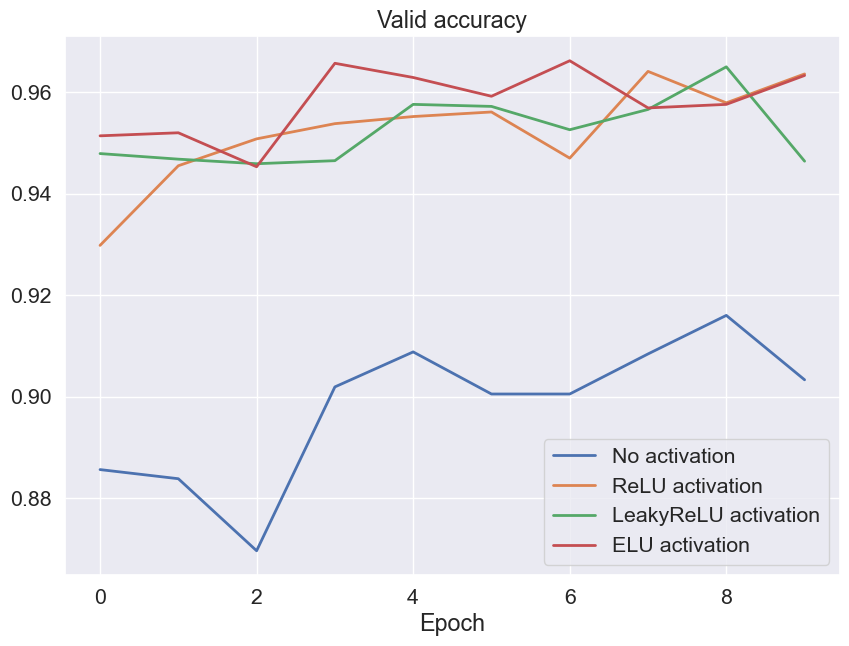

In [34]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(10, 7))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

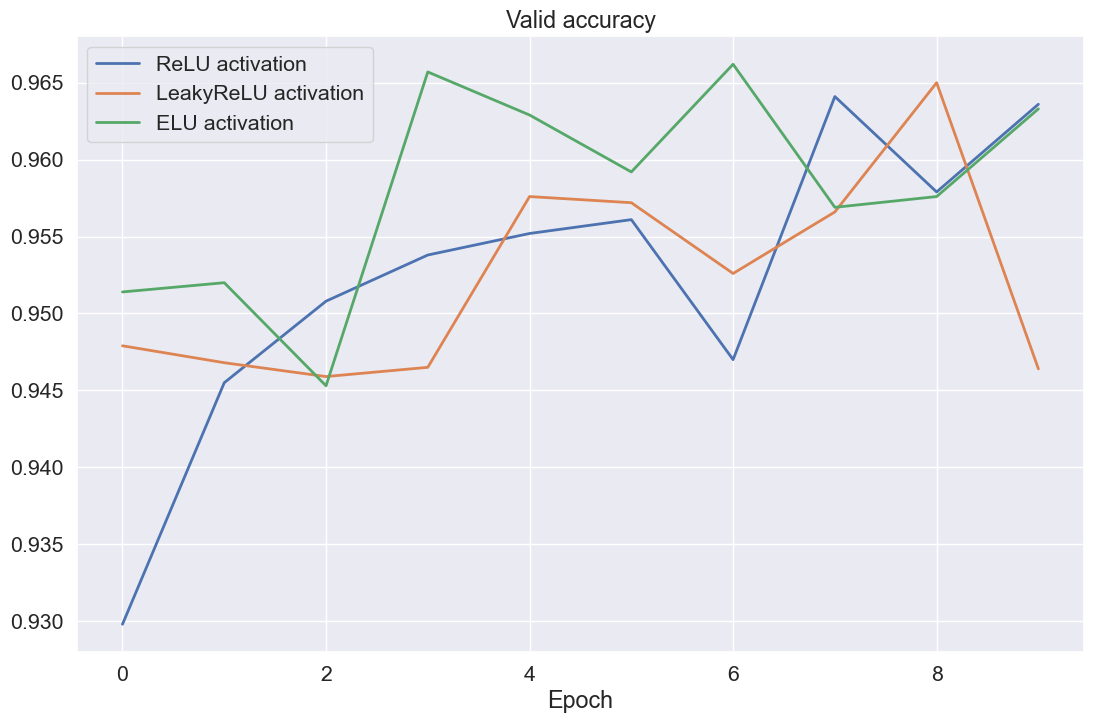

In [36]:
plt.figure(figsize=(13, 8))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

### Conclusions according to the schedule
+ At the end of the training the most accurate result shows the neural networks with ELU and LeakyReLU activation functions

## Part 2.2 Сonvolutional neural networks

### Realization of LeNet

If we make convolution parameters trainable, we can achieve good results for computer vision problems. Implement the LeNet architecture proposed back in 1998!
This time, use a modular structure (without the help of the Sequential class).

Our neural network will consist of
* 3x3 convolutions (1 map in, 6 out) with ReLU activation;
* MaxPooling 2x2;
* 3x3 convolutions (6 maps in, 16 maps out) with ReLU activation;
* MaxPooling 2x2;
* Flattening (nn.Flatten);
* Fully connected layer with 120 neurons and ReLU activation;
* Fully connected layer with 84 neurons and ReLU activation;
* Output layer of 10 neurons.




In [62]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [63]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [64]:
a = torch.randn(4, 4)
print(a.shape, a.view(-1, 16).shape)


torch.Size([4, 4]) torch.Size([1, 16])


### Training CNN

In [65]:
%%time
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                 model.train()
                 optimizer.zero_grad()
                 outp = model(x_batch)
            else:
                 model.eval()
                 with torch.no_grad():
                   outp = model(x_batch)
            preds = outp.argmax(-1)
            correct = (preds.flatten() == y_batch).type(torch.float64).sum()
            all =  y_batch.size()[0]
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                 loss = criterion(outp, y_batch)
                 loss.backward()
                 optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.9561
Loader: valid. Accuracy: 0.9827
Epoch: 2
Loader: train. Accuracy: 0.98295
Loader: valid. Accuracy: 0.9879
Epoch: 3
Loader: train. Accuracy: 0.9870833333333333
Loader: valid. Accuracy: 0.9892
Epoch: 4
Loader: train. Accuracy: 0.98905
Loader: valid. Accuracy: 0.9881
Epoch: 5
Loader: train. Accuracy: 0.9904
Loader: valid. Accuracy: 0.9867
Epoch: 6
Loader: train. Accuracy: 0.9916
Loader: valid. Accuracy: 0.9874
Epoch: 7
Loader: train. Accuracy: 0.9927833333333334
Loader: valid. Accuracy: 0.9878
Epoch: 8
Loader: train. Accuracy: 0.9923666666666666
Loader: valid. Accuracy: 0.9868
Epoch: 9
Loader: train. Accuracy: 0.9933166666666666
Loader: valid. Accuracy: 0.9882
Epoch: 10
Loader: train. Accuracy: 0.9938333333333333
Loader: valid. Accuracy: 0.9859
CPU times: total: 1h 15min 24s
Wall time: 17min 17s


In [66]:
lenet_accuracy = accuracy["valid"]

### Comparison with the previous FC NN.

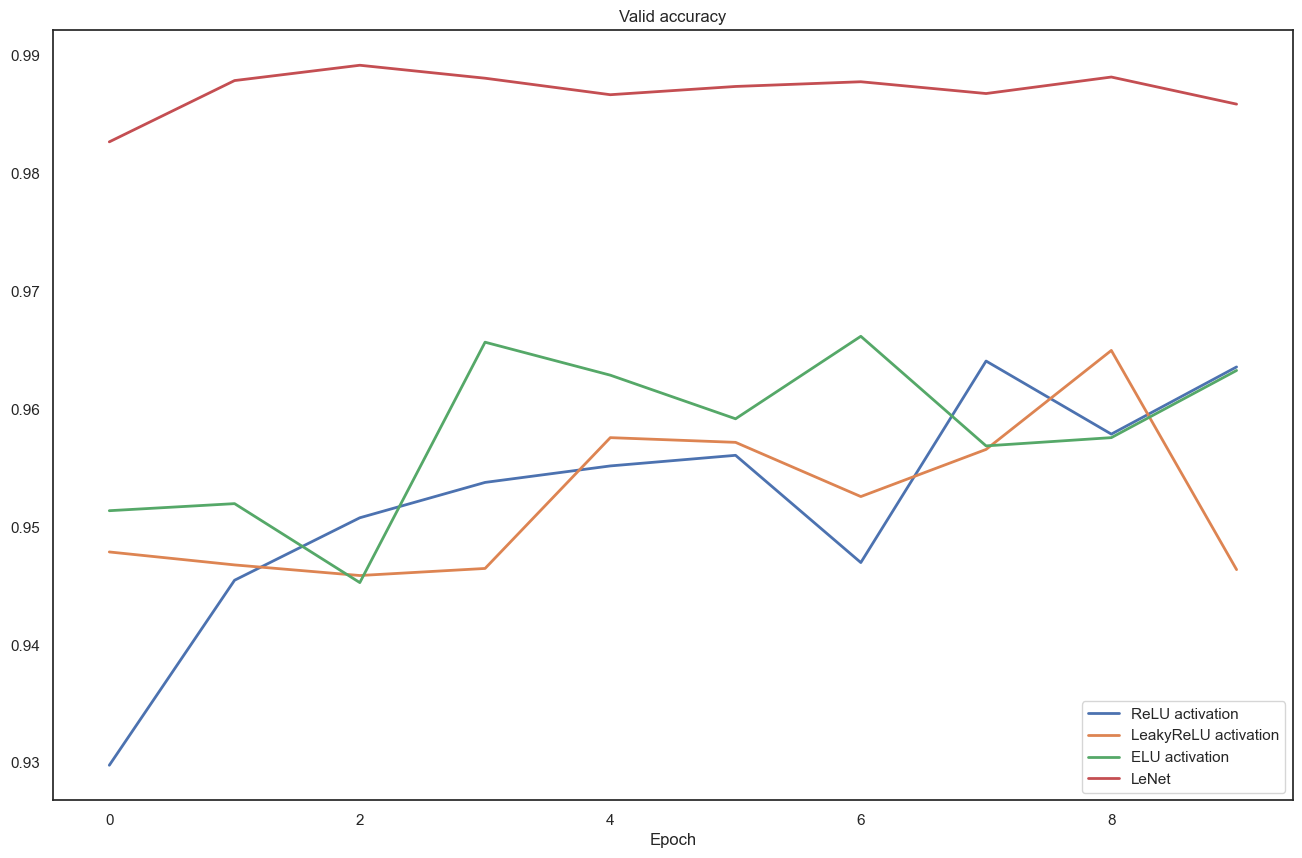

In [67]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

+ **As expected, the convolutional neural network performed significantly better than fully connected neural networks.**